In [1]:
import pandas as pd
import numpy as np
import datetime
import time 
import os
import gc
import re
import sys
from functools import partial
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from utils import ignore_warnings, load_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train = load_data('train')#, nrows=1000000)
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
fprint(train, 'train')
train = train[(train.action_type == 'clickout item') & (train.impressions.notna())]
fprint(train, 'train')

train shape: (15,932,992, 12)
train shape: (1,586,586, 12)


In [3]:
%%time
def session_duration(x):
    return x.max() - x.min()
# session_fts = train.groupby('session_id').agg({'session_id': 'size', 'timestamp': session_duration})
session_fts = train.groupby('session_id').size().reset_index(name='session_size')

CPU times: user 1.14 s, sys: 3.67 ms, total: 1.14 s
Wall time: 1.14 s


In [4]:
# from clean_session import preprocess_sessions
# # train = preprocess_sessions(train,data_source='data')
# train = preprocess_sessions(None,data_source='data')

In [5]:
# %%time
# train_last = train.groupby('session_id').last().reset_index()

In [6]:
train_last = train.copy()

In [7]:
del train
gc.collect()

32

In [8]:
train_last = pd.merge(train_last, session_fts, on='session_id')
fprint(train_last, 'train_last')

train_last shape: (1,586,586, 13)


---

In [9]:
# get only common cities
city_counts = train_last.city.value_counts()
city_counts_cs = city_counts.cumsum()/(city_counts.sum())
city_counts_cs.head()

London, United Kingdom    0.017958
Tokyo, Japan              0.032792
Paris, France             0.045143
New York, USA             0.056589
Istanbul, Turkey          0.066274
Name: city, dtype: float64

In [10]:
# set the threshold we select cities
th = 0.9
above_th = city_counts_cs[city_counts_cs<th]
common_cities = above_th.index.values
train_last = train_last[train_last.city.isin(common_cities)].reset_index(drop=True)
fprint(train_last, 'train_last')

train_last shape: (1,427,926, 13)


In [11]:
# current filters
train_last['cfs'] = train_last.current_filters.str.split('|')
train_last['ncfs'] = train_last.cfs.str.len()

In [12]:
# add country infomation
train_last['country'] = train_last.city.str.split(',').str[1]

In [13]:
# number of impressions
train_last['nimps'] = train_last.impressions.str.split('|').str.len()

In [14]:
# prices
train_last['prices'] = train_last.prices.str.split('|')
# train_last['prices'] = train_last.prices.apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))
train_last['prices'] = train_last.prices.apply(lambda x: [int(p) for p in x])

In [15]:
%%time
# impressions
train_last['impressions'] = train_last['impressions'].str.split('|')
# train_last['impressions'] = train_last['impressions'].apply(lambda x: np.pad(x, (0, 25-len(x)), mode='constant'))

CPU times: user 2.63 s, sys: 332 ms, total: 2.97 s
Wall time: 2.96 s


In [16]:
# select only 25 length
train_last = train_last[train_last['nimps']==25].reset_index(drop=True)
fprint(train_last, 'train_last')

train_last shape: (1,151,786, 17)


In [17]:
# create mapping and get unique count
all_imps = train_last['impressions'].values
imps_uniqes = list(set([j for i in all_imps for j in i]))
imps_mapping = {v: k for k,v in enumerate(imps_uniqes)}
del all_imps
n_item_ids = len(imps_uniqes)
del imps_uniqes

In [18]:
fprint(train_last, 'Before')
train_last = train_last[train_last.reference.notna()].reset_index(drop=True)
fprint(train_last, 'After')

def assign_target(row):
    ref = row.reference
    imp = list(row.impressions)
    if ref in imp:
        return imp.index(str(ref))
    else:
        return 25
train_last['target'] = train_last.apply(assign_target, axis=1)

Before shape: (1,151,786, 17)
After shape: (1,151,786, 17)


In [19]:
pd.value_counts(train_last['target']).head()

0    367453
1    109899
2     78934
3     64595
4     56264
Name: target, dtype: int64

In [20]:
# encode city, platform and device
def categorize(df, cols):
    for col in cols:
        print('converting', col)
        unique_values = df[col].unique()
        mapping = {v: k for k, v in enumerate(unique_values)}
        df[col] = df[col].map(mapping)
        
categorize(train_last, ['city', 'platform', 'device', 'country'])

converting city
converting platform
converting device
converting country


In [21]:
train_last.device.unique()

array([0, 1, 2])

In [22]:
train_last = pd.get_dummies(train_last, columns=['device'], drop_first=True)

In [23]:
# train = train[['session_id', 'timestamp', 'reference', 'imps', 'city', 'device', 'platform', 'prices']]

In [24]:
all_prices = train_last.prices.values
all_prices = [j for i in all_prices for j in i]

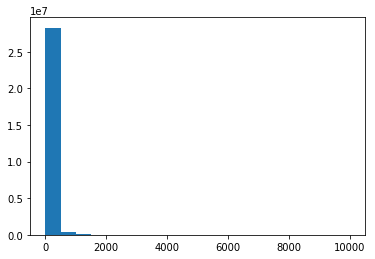

In [25]:
_= plt.hist(all_prices, bins=20)

In [26]:
np.max(all_prices), np.min(all_prices[all_prices!=0]), np.mean(all_prices), np.median(all_prices)

(10000, 66, 119.9751987956096, 83.0)

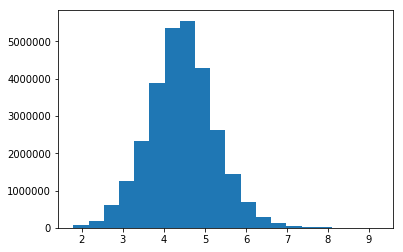

In [27]:
_= plt.hist(np.log1p(all_prices), bins=20)

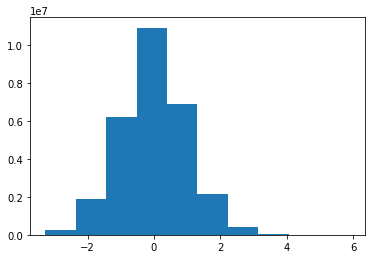

In [28]:
m = np.mean(np.log1p(all_prices))
sd = np.std(np.log1p(all_prices))
_ = plt.hist((np.log1p(all_prices)-m)/sd)

In [29]:
# all_prices = np.log1p(all_prices)
# price_mu = np.mean(all_prices)
# price_sd = np.std(all_prices)
# transform
# prices = np.array(list(np.log1p(train_last['prices'].values)))
# prices = (prices - price_mu)/price_sd
# del train_last['prices']
# maybe normalize to percentage within each records, check does each item_id have the same price over all records

def normalize(ps):
    p_arr = np.array(ps)
    return p_arr/(p_arr.max())

train_last['prices'] = train_last['prices'].apply(normalize)
prices = np.array(list(train_last['prices'].values))
del train_last['prices']

In [30]:
# IMPRESSIONS
impressions = train_last['impressions'].values
# map each item_id to integer value
impressions = np.array([[imps_mapping[j] for j in i] for i in impressions])
del train_last['impressions']
# CITY
cities = train_last['city'].values
n_city = train_last['city'].nunique()
del train_last['city']
# COUNTRY
countries = train_last['country'].values
n_country = train_last['country'].nunique()
del train_last['country']
# PLATFORM
platforms = train_last['platform'].values
n_plat = train_last['platform'].nunique()
del train_last['platform']
# DEVICES
devices = train_last[['device_1', 'device_2']].values
del train_last['device_1'], train_last['device_2']

# SESSION_ID
sids = train_last['session_id'].values
del train_last['session_id']
# TARGETS
targets = train_last['target'].values
del train_last['target']

In [31]:
def iterate_minibatches(impressions, prices, cities, countries, platforms, devices, 
                        batchsize, targets, shuffle=True, reorder=True):
    '''
        same as get_minibatches, except returns a generator
        inputs: An array of events, where each events is an array with sequence_length number of rows
        targets: target created by shifting 1 from inputs
        batchsize: desired batch size
        shuffle: Shuffle input data
    '''
    # default we will shuffle
    indices = np.arange(len(targets))
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, len(targets), batchsize):
            excerpt = indices[start_idx:start_idx+batchsize]
            imps = impressions[excerpt]
            ps = prices[excerpt]
            cis = cities[excerpt]
            cos = countries[excerpt]
            plats = platforms[excerpt]
            ds = devices[excerpt]
            ys = targets[excerpt]
            
            if reorder:
                # randomly shuffle the order of the impressions and prices
                reorder_ind = [np.random.choice(np.arange(25, dtype='int'), 25, replace=False) for _ in range(len(imps))]
                reorder_imp = imps[np.arange(imps.shape[0])[:, None], reorder_ind]
                reorder_price = ps[np.arange(ps.shape[0])[:, None], reorder_ind]
        
                # concatenate them back
                yield ([np.vstack((imps, reorder_imp)),
                        np.vstack((ps, reorder_price))[:, :, None],
                        np.hstack((cis, cis)), 
                        np.hstack((cos, cos)), 
                        np.hstack((plats, plats)),
                        np.vstack((ds, ds))],
                       np.vstack((ys, ys)))
#                 yield ([reorder_imp, reorder_price[:, :, None], cis, cos, plats, ds], ys)
            else:
                yield ([imps, ps[:, :, None], cis, cos, plats, ds], ys)

In [32]:
# from sklearn.metrics import roc_auc_score
# from keras.callbacks import Callback

# class IntervalEvaluation(Callback):
#     def __init__(self, validation_data=val_gen, y_val, interval=2):
#         super(Callback, self).__init__()

#         self.interval = interval
# #         self.X_val, self.y_val = validation_data
#         self.val_gen = val_gen
#         self.y_val = y_val

#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % self.interval == 0:
#             y_pred = self.model.predict_generator(self.val_gen, verbose=0)
# #             score = roc_auc_score(self.y_val, y_pred)
#             val_mrr = np.mean(1/(np.where(np.argsort(y_pred)[:, ::-1] == y_val[val_pred.shape[0]].reshape(-1, 1))[1]+1))
#             print("interval evaluation - epoch: {:d} - score: {:.6f}".format(epoch, val_mrr))

In [33]:
def nemd(n):
    return int(n**(1/4))

In [34]:
n_item_ids, nemd(n_item_ids)

(569125, 27)

In [36]:
n_city, n_country

(4309, 141)

In [37]:
nemd(n_city), nemd(n_country)

(8, 3)

In [38]:
nemd(n_plat)

2

In [ ]:
# for i in val_gen:
#     for j in i[0]:
#         print(j.shape)
#     break

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import StratifiedKFold
from datetime import datetime as dt
from nn_model import build_model
from keras.utils import plot_model

batchsize = 256

skf = StratifiedKFold(n_splits=5)
for trn_ind, val_ind in skf.split(targets, targets):
    trn_imp, val_imp = impressions[trn_ind], impressions[val_ind]
    trn_price, val_price = prices[trn_ind], prices[val_ind]
    trn_city, val_city = cities[trn_ind], cities[val_ind]
    trn_country, val_country = countries[trn_ind], countries[val_ind]
    trn_plat, val_plat = platforms[trn_ind], platforms[val_ind]
    trn_dev, val_dev = devices[trn_ind], devices[val_ind]
    
    y_trn, y_val = targets[trn_ind], targets[val_ind]
    # keras requires 0, 1 binary label input
    from keras.utils import to_categorical
    train_y_binary = to_categorical(y_trn)
    val_y_binary = to_categorical(y_val)
    
    
    # create data generator [imps, ps, cis, cos, plats, ds], ys
    train_gen = iterate_minibatches(trn_imp, trn_price, trn_city, trn_country, trn_plat, trn_dev, 
                        batchsize, train_y_binary, shuffle=True, reorder=True)
    
    val_gen = iterate_minibatches(val_imp, val_price, val_city, val_country, val_plat, val_dev, 
                    batchsize, val_y_binary, shuffle=False, reorder=False)
    # TEMP
#     del impressions, prices, cities, platforms, devices
#     gc.collect()
    
    # =====================================================================================
    # create model
    model = build_model(n_item_ids, n_city, n_country, n_plat)
    
    # print out model info
    nparams = model.count_params()
    print((f'train len: {len(y_trn):,} | val len: {len(y_val):,} '
           f'| numer of parameters: {nparams:,} | train_len/nparams={len(y_trn)/nparams:.5f}'))
    print(model.summary())
    plot_model(model, to_file='model.png')
    # add some callbacks
    callbacks = []
#     model_file = 'test.model'
#     callbacks = [ModelCheckpoint(model_file, save_best_only=True, verbose=1)]
    log_dir = "logs/{}".format(dt.now().strftime('%m-%d-%H-%M'))
    tb = TensorBoard(log_dir=log_dir, write_graph=True, write_grads=True)
    callbacks.append(tb)
    # add mrr callback
#     callbacks.append(IntervalEvaluation())
    
    batch_size = 256
    n_epochs = 10

    history = model.fit_generator(train_gen, 
                                  steps_per_epoch=len(y_trn)//batch_size, 
                                  epochs=10, 
                                  verbose=1, 
                                  callbacks=callbacks, 
                                  validation_data=val_gen, 
                                  validation_steps=len(y_val)//batch_size)

    # make predictions
     # train generator
    train_gen = iterate_minibatches(trn_imp, trn_price, trn_city, trn_country, trn_plat, trn_dev, 
                        batchsize, train_y_binary, shuffle=True)
    
    val_gen = iterate_minibatches(val_imp, val_price, val_city, val_country, val_plat, val_dev, 
                    batchsize, val_y_binary, shuffle=False, reorder=False)
    
    
    trn_pred = model.predict_generator(train_gen, steps=len(y_trn)//batch_size)
    trn_mrr = np.mean(1/(np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]+1))
    
    
    trn_pred = model.predict(x=[trn_imp, trn_price[:, :, None], trn_city, trn_country, trn_plat, trn_dev], 
                             batch_size=1024)
    trn_mrr = np.mean(1/(np.where(np.argsort(trn_pred)[:, ::-1] == y_trn.reshape(-1, 1))[1]+1))

    val_pred = model.predict(x=[val_imp, val_price[:, :, None], val_city, val_country, val_plat, val_dev], 
                             batch_size=1024)
    val_mrr = np.mean(1/(np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1]+1))
    print(f'train mrr: {trn_mrr:.2f} | val mrr: {val_mrr:.2f}')
    
    
    break

train len: 921,418 | val len: 230,368 | numer of parameters: 11,434,012 | train_len/nparams=0.08059
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
impression_input (InputLayer)   (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 20)       11382500    impression_input[0][0]           
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 25, 20)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 23, 16)       976         spatial_dropout1d_1[0][0]        
_________

Epoch 1/10
3599/3599 [==============================] - 57s 16ms/step - loss: 2.6461 - acc: 0.3136 - val_loss: 2.5811 - val_acc: 0.3193
Epoch 2/10
3599/3599 [==============================] - 56s 16ms/step - loss: 2.5552 - acc: 0.3190 - val_loss: 2.5610 - val_acc: 0.3194
Epoch 3/10
3599/3599 [==============================] - 56s 16ms/step - loss: 2.5216 - acc: 0.3191 - val_loss: 2.5625 - val_acc: 0.3187
Epoch 4/10
1573/3599 [============>.................] - ETA: 30s - loss: 2.4934 - acc: 0.3192

In [ ]:
pd.value_counts(np.where(np.argsort(val_pred)[:, ::-1] == y_val.reshape(-1, 1))[1])

In [ ]:
# train mrr: 0.47 | val mrr: 0.45